# Inscopix CNMFe Demo

This notebook demonstrates how to use the Inscopix CNMFe package to extract and visualize the spatial footprints and temporal dynamics of neurons in a 1-photon calcium imaging movie recorded in the mouse dorsal striatum. Before using this notebook, you will need to install the dependencies listed below:

`pip install inscopix-cnmfe matplotlib`

## Import required packages

In [1]:
import inscopix_cnmfe
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Run cnmfe on a sample movie

In [2]:
footprints, traces = inscopix_cnmfe.run_cnmfe(
    input_movie_path='test/data/movie.tif', 
    output_dir_path='output', 
    output_filetype=0,
    average_cell_diameter=7,
    min_corr=0.8,
    min_pnr=10.0,
    gaussian_kernel_size=0,
    closing_kernel_size=0,
    background_downsampling_factor=2,
    ring_size_factor=1.4,
    merge_threshold=0.7,
    num_threads=4,
    processing_mode=2,
    patch_size=80,
    patch_overlap=20,
    trace_output_units=1
)

# Visualize the spatial footprint and temporal dynamics of neurons identified using CNMFe

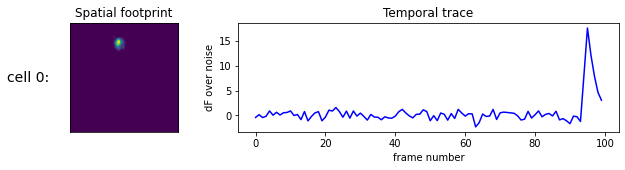

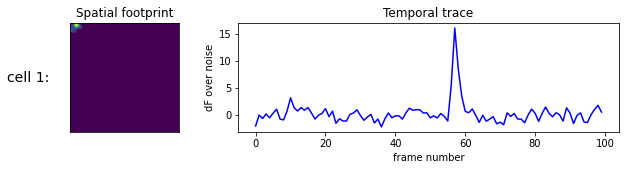

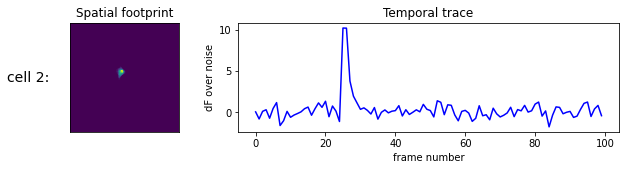

In [3]:
# number of neurons we wish to visualize
num_neurons = 3

for neuron_index in range(num_neurons):
    # instantiate figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 3]})

    # spatial footprint
    axes[0].imshow(footprints[neuron_index])
    axes[0].set_title("Spatial footprint")
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # temporal dynamics
    axes[1].set_title("Temporal trace")
    axes[1].plot(traces[neuron_index], label='neuron {0}'.format(neuron_index), color='blue')
    axes[1].set_ylabel("dF over noise")
    axes[1].set_xlabel("frame number")
    
    plt.suptitle(
        'cell {0}:'.format(neuron_index), 
        x=0.08,
        y=0.55,
        fontsize=14
    )

    plt.show()

## View all cell footprints in a grid

In [4]:
def plot_footprints_on_grid(footprints, n_cols = 10):
    '''
    Plots all footprints on a grid of axes.
    User specifies number of desired columns
    
    Args:
        footprints (array):
            n_cells x rows x columns array of footprints
        n_cols (int, optional):
            number of columns in plot grid (defaults to 10).
    Returns:
        tuple of fig, ax
            fig = matplotlib figure handle
            ax = array of matplotlib axes handles
    '''

    n_rows = int(np.ceil(np.shape(footprints)[0]/n_cols))
    
    fig, ax = plt.subplots(
        n_rows, 
        n_cols, 
        figsize=(12,1.6*n_rows), 
        sharex=True, 
        sharey=True
    )
    axes = ax.ravel()
    
    for i in range(len(ax.flatten())):
        try:
            axes[i].imshow(footprints[i], cmap='gray')
            axes[i].set_title("cell {}".format(str(i).zfill(2)))
            axes[i].grid(False)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
        except IndexError:
            # turn off axes for where cell doesn't exist
            axes[i].axis('off')
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.025, hspace=0.2, top=0.93)
    fig.patch.set_facecolor('white')
    fig.suptitle('all spatial footprints', fontweight='bold');

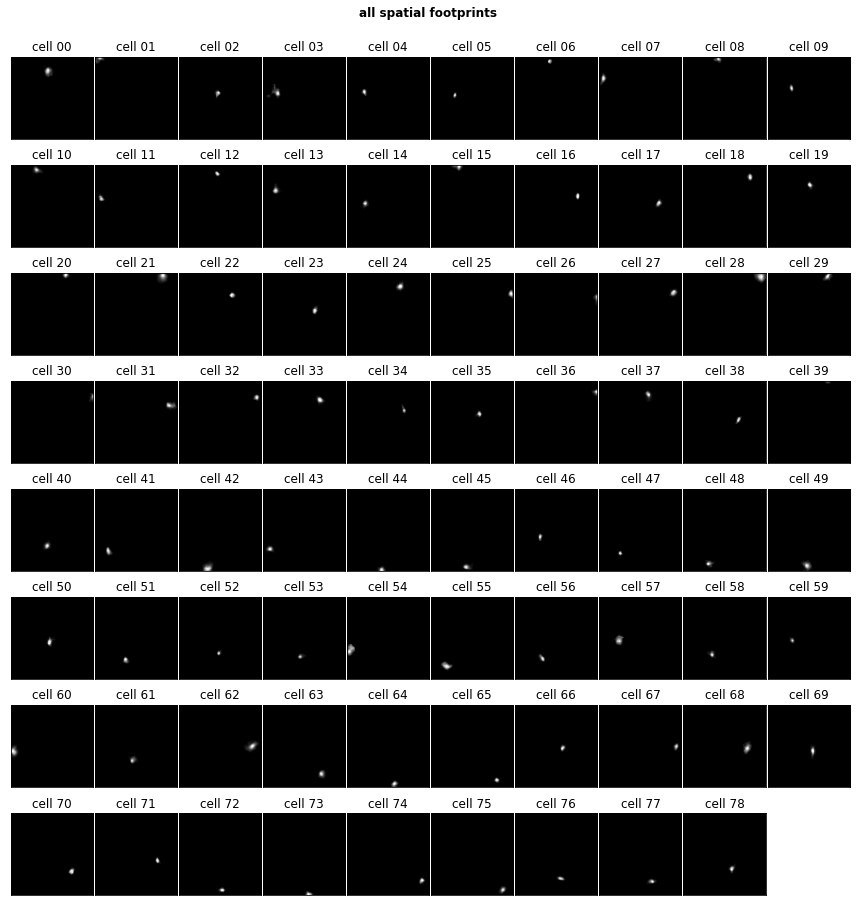

In [5]:
plot_footprints_on_grid(footprints)

## Create a composite image of all ROIS in the field of view
The same random color assigned to the trace will be assigned to the ROI

In [6]:
def plot_composite_fov(footprints, colormap='gist_rainbow'):
    '''
    Plots all footprints on a single composite field of view.
    
    Args:
        footprints (array):
            n_cells x rows x columns array of footprints
        colormap (str, optional)
            Colormap to use. Each cell will be assigned a random color from this map (defaults to 'gist_rainbow').
    Returns:
        tuple of fig, ax
            fig = matplotlib figure handle
            ax = matplotlib axis handle
    '''
    
    fig, ax = plt.subplots(figsize=(15,15))
    
    # start with an array of zeros
    composite_fov = np.zeros((footprints.shape[1], footprints.shape[2], 3))
    cmap_vals = cm.get_cmap(colormap)
    
    np.random.seed(0)
    for cell_id in range(footprints.shape[0]):
        # select a random color for this cell
        color = cmap_vals(np.random.rand())

        # assign the color to each of the three channels, normalized by the footprint peak
        for color_channel in range(3):
            composite_fov[:,:,color_channel] += color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])

    # set all values > 1 (where cells overlap) to 1:
    composite_fov[np.where(composite_fov > 1)] = 1

    # show the image
    ax.imshow(composite_fov)

    # annotate each cell with a label centered at its peak
    for cell_id in range(footprints.shape[0]):
        peak_loc = np.where(footprints[cell_id]==np.max(footprints[cell_id]))
        ax.text(
            peak_loc[1][0], 
            peak_loc[0][0], 
            'cell {}'.format(str(cell_id).zfill(2)), 
            color='white', 
            ha='center', 
            va='center',
            fontweight='bold',
        )
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.patch.set_facecolor('white')
    fig.suptitle('composite field of view', fontweight='bold');
    
    return fig, ax

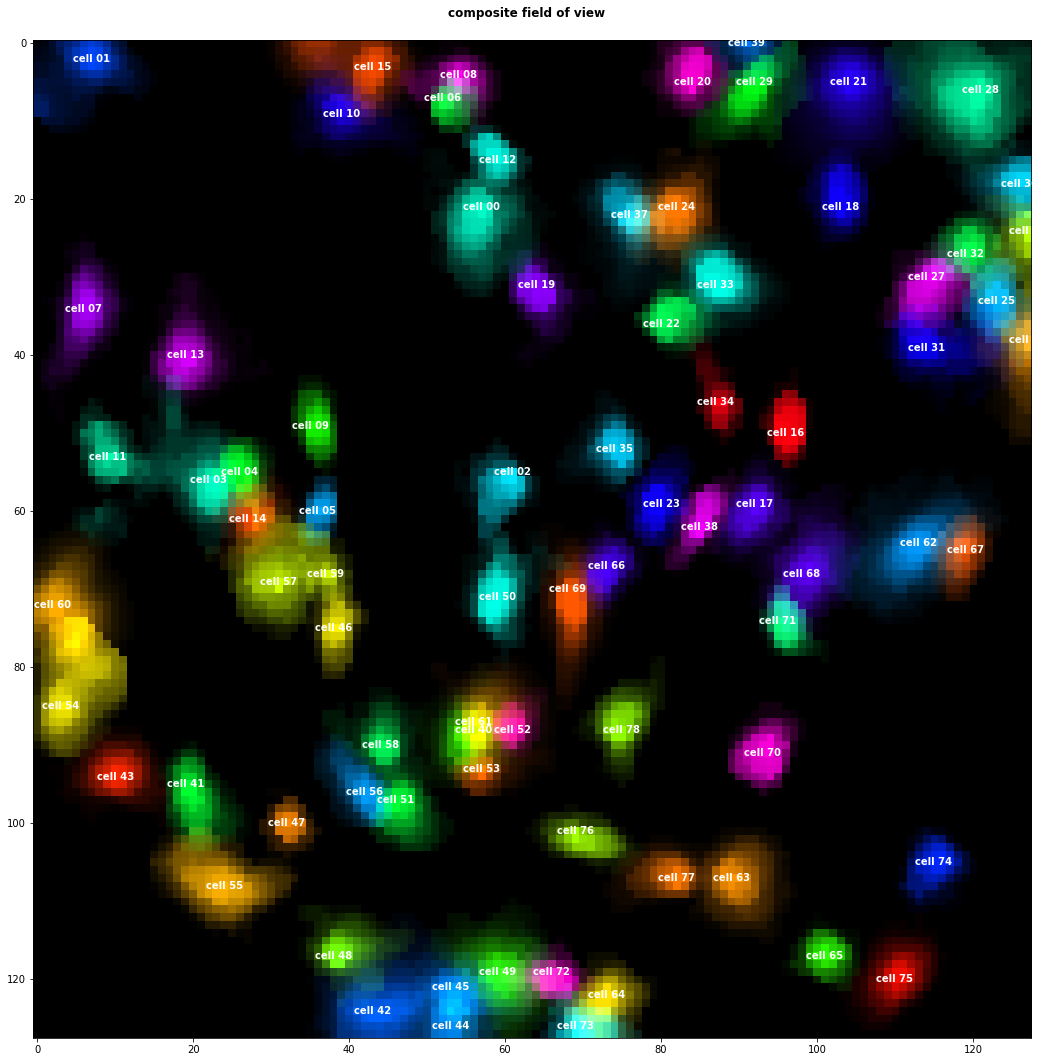

In [7]:
plot_composite_fov(footprints, colormap='gist_rainbow');

## View all cell traces
A random color will be assigned to each trace.  
Each trace is aligned such that its first point aligns with the tick corresponding to its label. 

In [8]:
def plot_all_traces(traces, spacing=5, height_per_row=0.5, colormap='gist_rainbow'):
    '''
    Plots all traces on a single axis
    
    Args:
        traces (Pandas.DataFrame):
            Dataframe of all traces with columns Frame and one column for each cell
        spacing (int, optional):
            Vertical spacing between traces (defaults to 5).
        height_per_row (float, optional)
            Vertical height in inches devoted to each cell in the plot (defaults to 0.5).
        colormap (str, optional)
            Colormap to use. Each row will be a random color from this map (defaults to 'gist_rainbow').
    Returns:
        tuple of fig, ax
            fig = matplotlib figure handle
            ax = matplotlib axis handle
    '''
    
    fig, ax = plt.subplots(figsize=(15, height_per_row*footprints.shape[0]))
    
    num_cells = traces.shape[0]
    cell_names = ['cell ' + str(i).zfill(2) for i in range(num_cells)]
    cmap_vals = cm.get_cmap(colormap)
    np.random.seed(0)
    for cell_index in range(num_cells):
        ax.plot(
            range(traces.shape[1]), 
            traces[cell_index] + -1*cell_index*spacing - traces[cell_index][0],
            linewidth=3,
            alpha=0.75,
            color= cmap_vals(np.random.rand())
        )
        
    ax.set_ylim(-1*spacing*len(cell_names)-spacing, 0+spacing*4)
    ax.set_yticks(np.arange(-1*spacing*(len(cell_names)-1), 0+spacing, spacing));
    ax.set_yticklabels(cell_names[::-1]);
    ax.set_xlim(0, traces.shape[1] - 1)
    ax.set_xlabel('time (s)')
    
    for side in ['left', 'top', 'right']:
        ax.spines[side].set_color('white')
        
    fig.patch.set_facecolor('white')
    fig.tight_layout()
    fig.subplots_adjust(top=0.98)
    fig.suptitle('all trace timeseries', fontweight='bold');
    return fig, ax


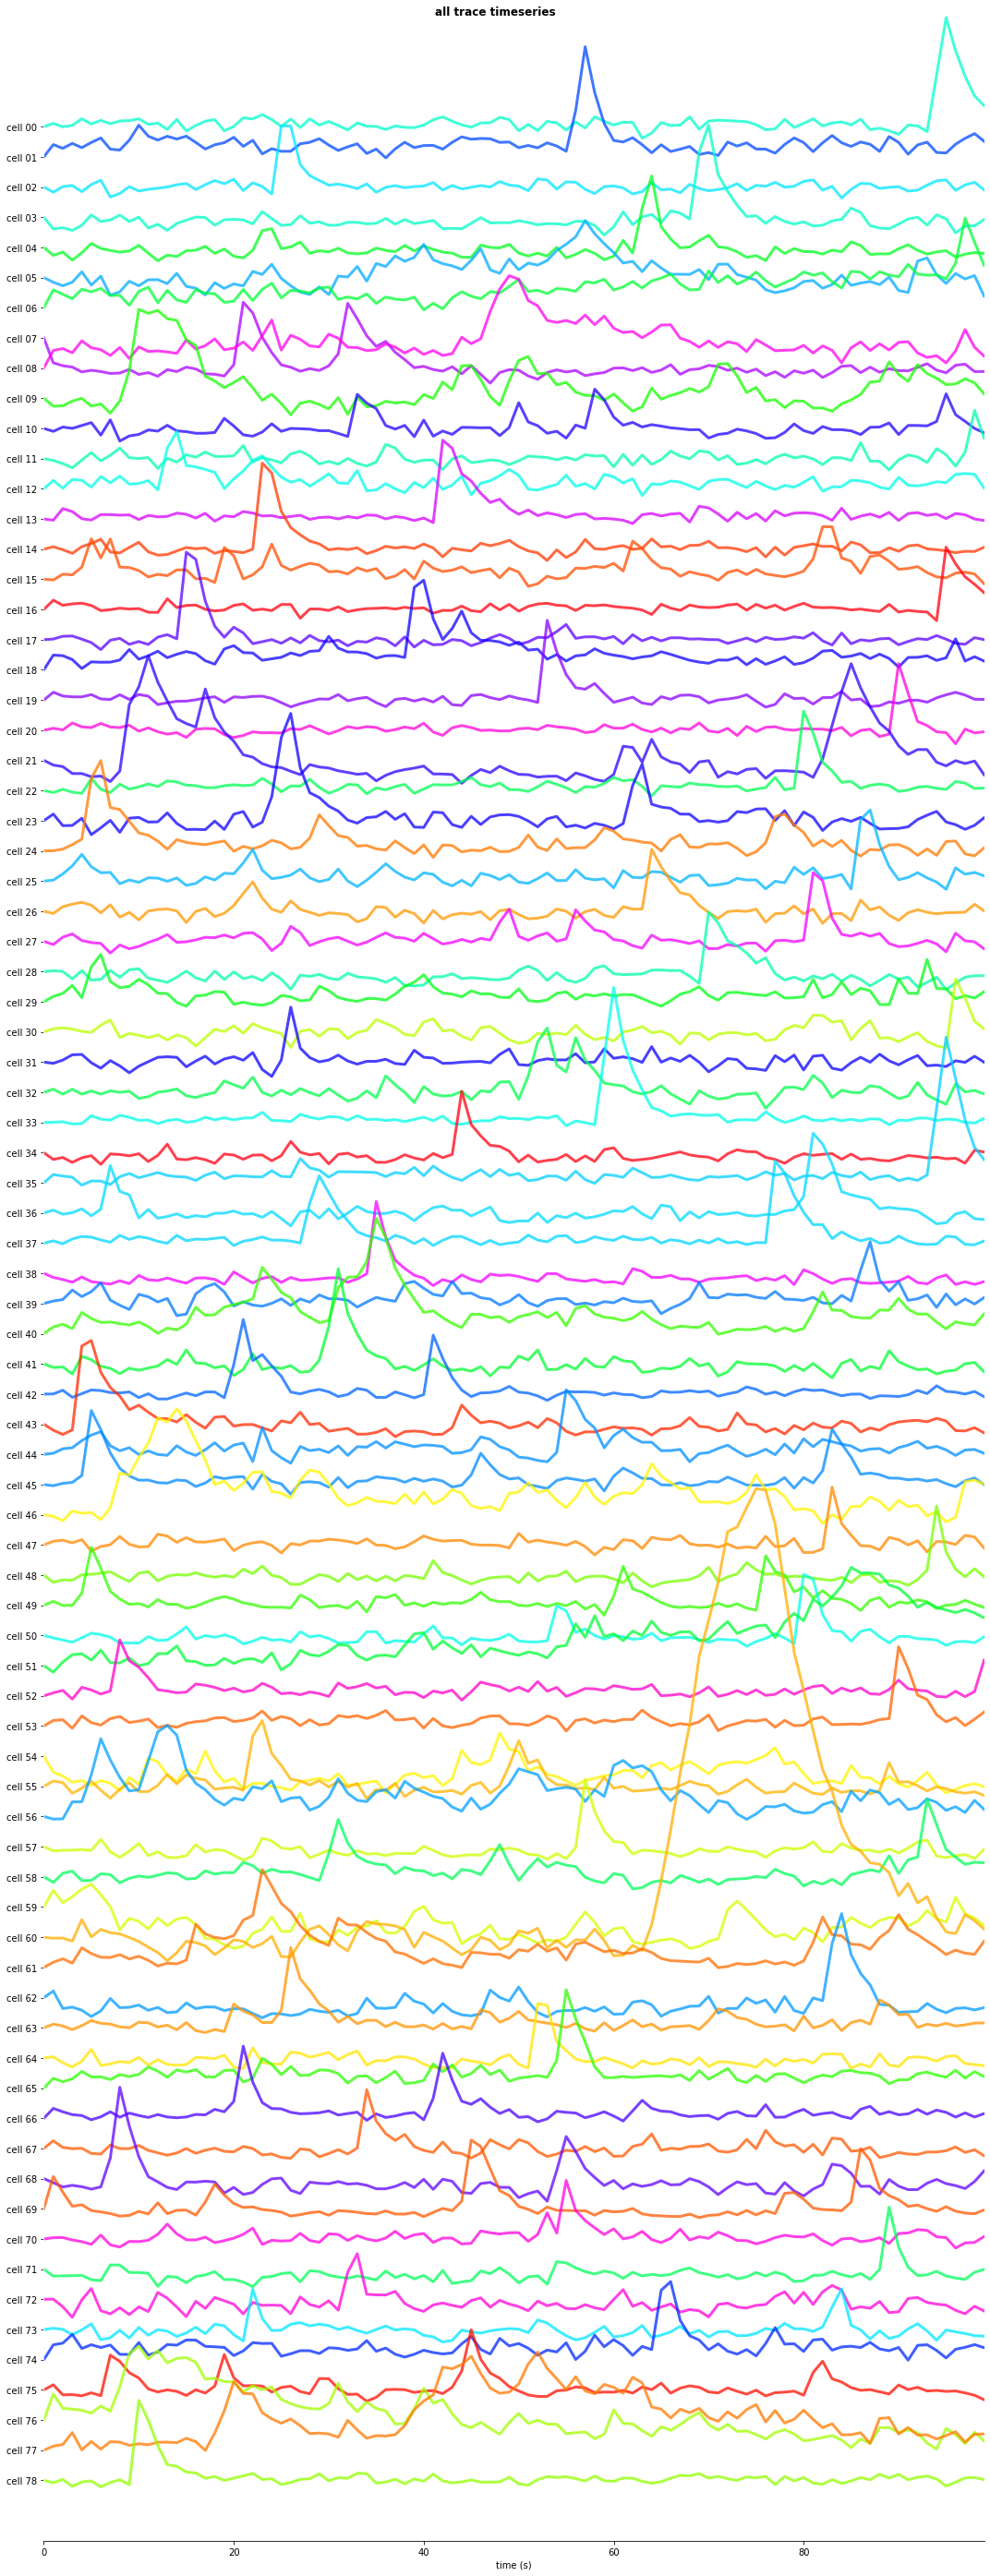

In [9]:
plot_all_traces(traces, spacing=5, height_per_row=0.5);